In [174]:
import json
import os
from langdetect import detect
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin
from dotenv import load_dotenv

# Read data from url

In [177]:
def fetch_json_from_url(url, depth=0):
    """Recursively fetch JSON files from given URL based on depth."""
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'lxml')
            for link in soup.select('tr.file a'):
                href = link['href'].strip()  # Strip whitespace from the href
                if href:
                    full_url = urljoin(url, href)

                    # Use regex to match dates and id in href and check depth conditions
                    if depth == 0 and re.search(r'\d{4}-\d{2}-\d{2}/$', href):
                        fetch_json_from_url(full_url, depth=1)
                    elif depth == 1 and re.search(r'\d+/$', href):
                        fetch_json_from_url(full_url, depth=2)
                    elif depth == 2 and href.endswith('.json'):
                        process_json_file(full_url)
        else:
            print(f"Failed to access {url}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

def process_json_file(json_url):
    """Fetch and process a JSON file."""
    response = requests.get(json_url)
    if response.status_code == 200:
        data = response.json()
        all_jobs.append(data)
    else:
        print(f"Failed to retrieve JSON from {json_url}")

# Access the start url using the variable name defined in the .env file
load_dotenv()
start_url = os.getenv('START_URL')

# Fetch all jobs 
all_jobs = []
fetch_json_from_url(start_url)
df = pd.DataFrame(all_jobs)
print(df.head())

                                             title            company  \
0  Mobile app (iOS/Android) developer | Gamebasics  Buro5 Recruitment   
1                                Software Engineer      Grid to Great   
2                   Lead Machine Learning Engineer             Enjins   
3                             Full Stack Developer      Belmont Lavan   
4                               Metaverse Engineer      Belmont Lavan   

                                 location                    entity_urn  \
0  Zoetermeer, South Holland, Netherlands  urn:li:jobPosting:3475631966   
1         Arnhem, Gelderland, Netherlands  urn:li:jobPosting:3478342608   
2           Utrecht, Utrecht, Netherlands  urn:li:jobPosting:3590302811   
3    Rijswijk, South Holland, Netherlands  urn:li:jobPosting:3590306744   
4   Amsterdam, North Holland, Netherlands  urn:li:jobPosting:3590311996   

           id                                            url        date  \
0  3475631966  https://www.linkedi

In [178]:
def lang_detect(text):
    try:
        ln = detect(text)
    except:
        ln = None
    return ln

df['language'] = df['text'].apply(lambda x: lang_detect(x)) # type: ignore

In [179]:
df.describe()

,title,company,location,entity_urn,id,url,date,level,industries,employment_type,text,language
count,1182,1182,1182,1182,1182,1182,1182,1182,1182,742,1182,1182
unique,666,613,177,1182,1182,1182,164,8,224,6,1048,6
top,Software Engineer,CIMSOLUTIONS,"Amsterdam, North Holland, Netherlands",urn:li:jobPosting:3475631966,3475631966,https://www.linkedin.com/jobs/view/3475631966,2024-07-05,Mid-Senior level,IT Services and IT Consulting,Full-time,We are looking for a mid/senior Python Develop...,nl
freq,50,40,245,1,1,1,89,503,224,694,8,625


In [180]:
df[df['date']>'2024-06-11']['date'].value_counts().sort_index(ascending=False)

2024-07-15     2
2024-07-14    57
2024-07-13    14
2024-07-12    84
2024-07-11    55
2024-07-10    47
2024-07-09    43
2024-07-08    13
2024-07-07     3
2024-07-06     9
2024-07-05    89
2024-07-04    44
2024-07-03    38
2024-07-02    25
2024-07-01    47
2024-06-30     2
2024-06-29    14
2024-06-28    31
2024-06-27    23
2024-06-26    30
2024-06-25    25
2024-06-24    29
2024-06-23     3
2024-06-22    26
2024-06-21    19
2024-06-20    18
2024-06-19    24
2024-06-18    19
2024-06-17    19
2024-06-16     1
2024-06-15     4
2024-06-14     8
2024-06-13    25
2024-06-12     9
Name: date, dtype: int64

### Analyze the trend of language requirment

In [181]:
df['language'].value_counts()

nl       625
en       549
pl         4
zh-cn      2
de         1
fr         1
Name: language, dtype: int64

In [182]:
df['is_english'] = (df['language']=='en')

In [ ]:
g = sns.relplot(data=df, x = 'date', y='is_english', kind='line')
g.figure.set_size_inches(8, 12)  
g.set_xticklabels(rotation=45)

### Analyze job titles

In [166]:
df['title'].unique()

array(['Mobile app (iOS/Android) developer | Gamebasics',
       'Software Engineer', 'Lead Machine Learning Engineer',
       'Full Stack Developer', 'Metaverse Engineer',
       'Unreal Engine Developers', 'Software Engineer Traineeship',
       'Natural Language Processing Engineer',
       'Full Stack Software Engineer | Rotterdam | Navara',
       'Full Stack Software Engineer | Amsterdam | Navara',
       'Data Scientist | Freshminds Data', 'Python Developer',
       'Data Scientist | Qualogy Solutions', 'Data scientist | Valcon NL',
       'Traineeship Data Science & Engineering | Educom',
       'Python Developer - Capelle a/d IJssel | ALTEN',
       'Python Developer | Alteza',
       'Data Scientist | Active Professionals',
       'Senior Machine Learning Engineer', 'Strategic Data Scientist',
       'Junior Software Engineer',
       'Python Developer - Amstelveen | ALTEN', 'SDE-ZY', 'SDE-供应商开发工程师',
       'Mendix App developer', 'Python developer (Tesla bedrijfswagen)',
   

In [167]:
from translate import Translator

#translator = Translator(from_lang="nl", to_lang="en")

def translate_text(text, language):
    try:
        translator = Translator(from_lang=language, to_lang="en")
        translation = translator.translate(text)
        return translation
    except Exception as e:
        print(f"An error occurred: {e}")
        return text
    
def get_english(text):
    language = lang_detect(text)
    if language =='en':
        return text
    else:
        return translate_text(text,language)

df['english_title'] = df['title'].apply(get_english)

In [168]:
# Function to group job titles
def group_title (title):
    title_lower = title.lower()
    if ('scientist' in title_lower) or ('data science' in title_lower):
        return 'Data Scientist'
    elif 'machine learning' in title_lower:
        return 'Machine Learning Engineer'
    elif 'developer' in title_lower:
        return 'Developer'
    # elif 'python' in title_lower:
    #     return 'Python Developer'
    elif 'engineer' in title_lower:
        return 'Engineer'
    else:
        return 'Other'

df['title_group'] = df['english_title'].apply(group_title)

print(df[['title','title_group']])

                                                title  \
0     Mobile app (iOS/Android) developer | Gamebasics   
1                                   Software Engineer   
2                      Lead Machine Learning Engineer   
3                                Full Stack Developer   
4                                  Metaverse Engineer   
...                                               ...   
1177                                 Python Developer   
1178          Senior Software Engineer (C++ / Python)   
1179                                   Data Scientist   
1180                                   Data Scientist   
1181               Senior Full Stack Python Developer   

                    title_group  
0                     Developer  
1                      Engineer  
2     Machine Learning Engineer  
3                     Developer  
4                      Engineer  
...                         ...  
1177                  Developer  
1178                   Engineer  
1179     

In [169]:
df['title_group'].value_counts()

Engineer                     471
Developer                    320
Data Scientist               270
Machine Learning Engineer     69
Other                         52
Name: title_group, dtype: int64

In [170]:
df[df['title_group']=='Other']['title'].value_counts()

Engineer                                                                                                                4
Robot Programmeur, Warmenhuizen                                                                                         3
Reliability Programmeur, Wieringerwerf                                                                                  2
Programmeur, Den Haag                                                                                                   2
Stanowisko ds. rozliczeń                                                                                                2
Stanowisko ds. egzekucji                                                                                                2
AI / Neuromorphic Researcher                                                                                            2
SDE-ZY                                                                                                                  1
PLC progammeur          

/Users/jianisong/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


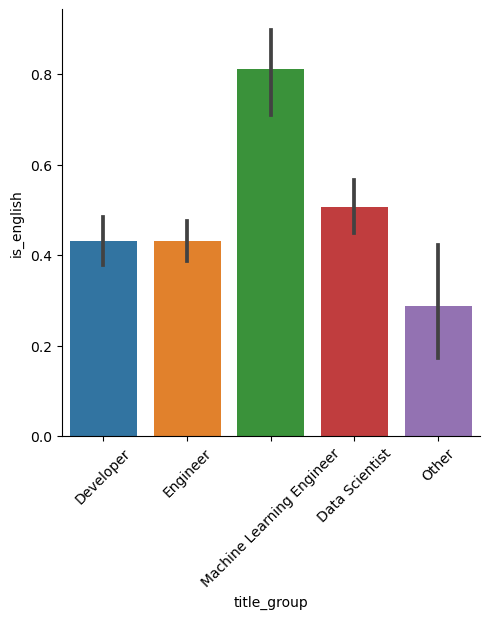

In [172]:
import seaborn as sns
g = sns.catplot(data=df, x = 'title_group', y='is_english', kind='bar')
g.set_xticklabels(rotation=45)